<a href="https://colab.research.google.com/github/dspuliaiev/Data_Science/blob/master/Hw10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
188/188 [==============================] - 27s 92ms/step - loss: 1.8566 - accuracy: 0.4556 - val_loss: 0.7834 - val_accuracy: 0.7202 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 16s 87ms/step - loss: 0.6595 - accuracy: 0.7776 - val_loss: 0.5797 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 17s 88ms/step - loss: 0.4471 - accuracy: 0.8635 - val_loss: 0.4364 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 17s 89ms/step - loss: 0.3423 - accuracy: 0.8963 - val_loss: 0.3137 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 17s 89ms/step - loss: 0.2914 - accuracy: 0.9102 - val_loss: 0.2898 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 17s 89ms/step - loss: 0.2601 - accuracy: 0.9187 - val_loss: 0.2635 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - 17s 

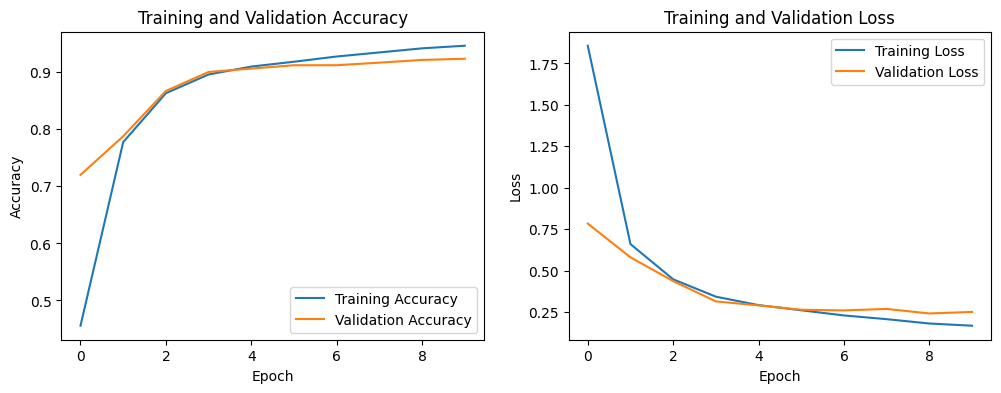

313/313 [==============================] - 2s 7ms/step


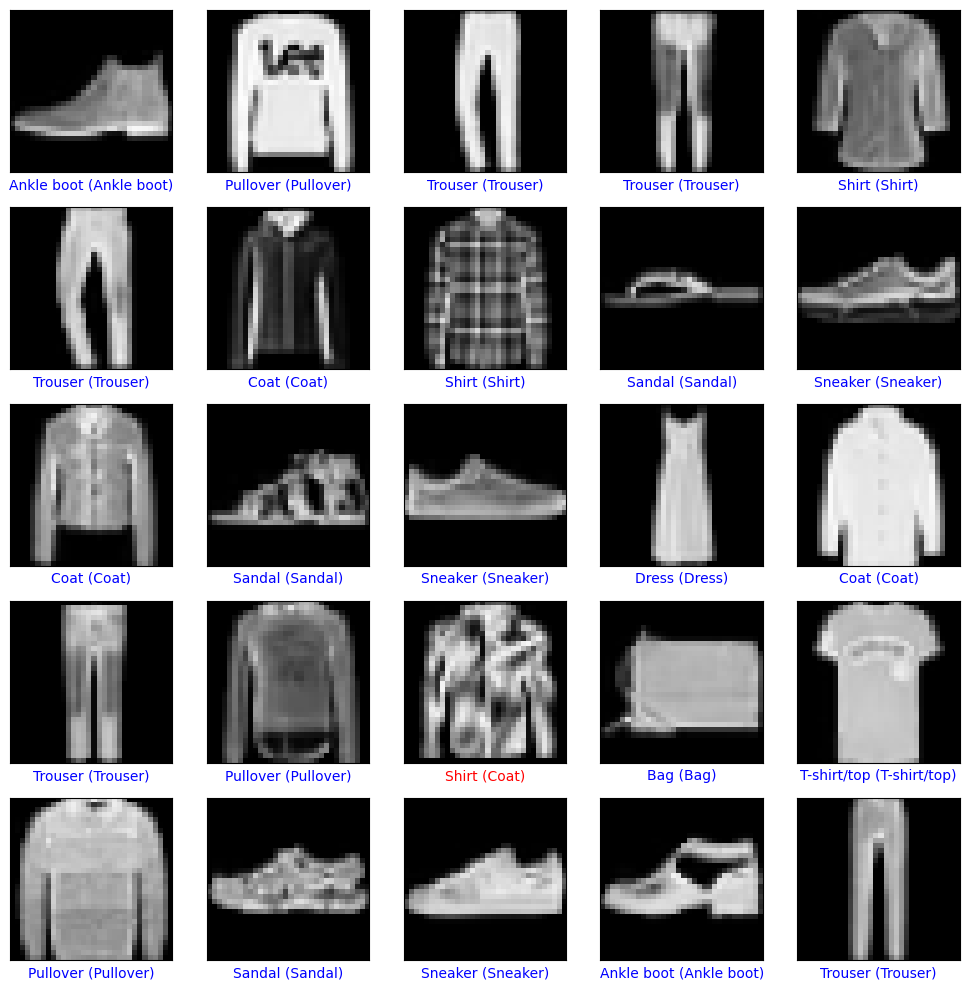

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Завантаження даних
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Нормалізація даних
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Зміна розмірності даних для VGG16
x_train = np.stack([x_train]*3, axis=-1)
x_test = np.stack([x_test]*3, axis=-1)

# Зміна розміру зображень до 32x32
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))

# Перетворення міток у категоріальний формат
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Побудова моделі на основі VGG16
def model_VGG16(learning_rate, epochs, batch_size):
    # Завантаження базової моделі VGG16 без верхніх шарів
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')

    # Додавання власних шарів
    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.4)(x)  # Збільшуємо Dropout для зменшення перенавчання
    predictions = layers.Dense(10, activation='softmax')(x)

    # Створення фінальної моделі
    model = Model(inputs=base_model.input, outputs=predictions)

    # Компіляція моделі
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Колбеки для ранньої зупинки та зменшення швидкості навчання
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    # Навчання моделі
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

    # Оцінка моделі на тестових даних
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f'Test Accuracy: {test_accuracy*100:.1f}%')

    return model, history

# Гіперпараметри
epochs = 10
batch_size = 256

# Навчання моделі
model, history = model_VGG16(learning_rate, epochs, batch_size)

# Візуалізація результатів
def plot_results(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_results(history)

# Прогнозуємо класи для тестових даних
predictions = model.predict(x_test)

# Перетворюємо прогнози на мітки класів
predicted_classes = np.argmax(predictions, axis=1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Візуалізація кількох зображень із тестового набору даних із передбаченими та дійсними мітками класів
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[true_label]),
                                color=color)

# Передбачення перших 25 зображень із тестового набору даних
num_rows = 5
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_image(predictions[i], y_test[i], x_test[i])
plt.tight_layout()
plt.show()


##Висновки:
Попередньо навчена модель VGG16, адаптована для нашого завдання, досягла точності 92,4%. Ця модель має кілька ключових переваг:

Швидкість навчання: Модель не потребує великої кількості епох, що значно прискорює процес навчання та класифікації.
Запобігання перенавчанню: При збільшенні кількості епох спостерігається тенденція до перенавчання, тому важливо контролювати цей параметр.
Ефективність передачі знань: Використання попередньо навченої моделі дозволяє ефективно застосувати знання, отримані на більших наборах даних.

Порівняно з попередньою згортковою моделлю, яка досягла точності 93,8%, модель на основі VGG16 показала дещо нижчу точність. Однак варто зазначити:

Час навчання: VGG16 потребує менше часу на навчання, що може бути критичним фактором у деяких застосуваннях.
Компроміс між точністю та швидкістю: Хоча попередня модель показала вищу точність, різниця в 1,4% може бути прийнятною, враховуючи переваги у швидкості та ефективності VGG16.
Потенціал для покращення: Існує можливість подальшої оптимізації моделі на основі VGG16, наприклад, шляхом тонкого налаштування гіперпараметрів або розморожування деяких шарів базової моделі.

Загалом, вибір між цими двома підходами залежить від конкретних вимог завдання: якщо пріоритетом є максимальна точність, попередня згорткова модель може бути кращим вибором. Якщо ж важлива швидкість навчання та ефективність використання обчислювальних ресурсів, модель на основі VGG16 може бути більш доцільною.
